# 3. MÉTRICAS E INDICADORES DE REDES


## 3.1 Obtenção e análise preliminar da rede viária


Inicialmente, instalamos a OSMnx no Google Colab.

In [1]:
# !pip install osmnx

Em seguida, importamos as bibliotecas necessárias para análise e visualização de redes. Além disso, configuramos o OSMnx para utilizar cache e exibir logs no console. Essas configurações facilitam o trabalho com redes urbanas.

In [2]:
import geopandas as gpd
import networkx as nx
from networkx import ego_graph
import osmnx as ox
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
import folium
import numpy as np
import pandas as pd

ox.config(use_cache=True, log_console=True)

/tmp/ipykernel_26445/3270492796.py:12: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.config(use_cache=True, log_console=True)


A análise será realizada no bairro da Liberdade, localizado em São Paulo, Brasil. Esse local será utilizado para obter a rede viária correspondente.

In [3]:
bairro = "Liberdade, São Paulo, Brasil"

Utilizamos a função `graph_from_place` do OSMnx para capturar a rede de ruas com o tipo de rede "drive" (ruas acessíveis por veículos motorizados).

In [4]:
grafo_rede_viaria = ox.graph_from_place(bairro, network_type='drive')

Plotamos a rede viária utilizando a função `plot_graph` para ter uma visualização inicial da área de estudo.

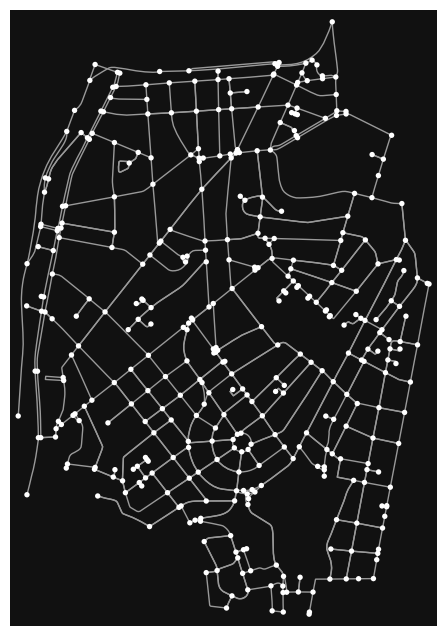

In [5]:
fig, ax = ox.plot_graph(grafo_rede_viaria)
plt.show()

A próxima etapa é converter os dados de atributos dos nós e arestas para DataFrames, facilitando a visualização e análise dos mesmos. A função `nodes(data=True)` é usada para extrair os atributos dos nós, que são transformados em um DataFrame.

In [6]:
df_nos = pd.DataFrame.from_dict(dict(grafo_rede_viaria.nodes(data=True)), orient='index')
print("Atributos dos Nós:")
print(df_nos.head())

Atributos dos Nós:
                  y          x  street_count          highway  ref
587993   -23.558210 -46.638256             3              NaN  NaN
25929414 -23.559053 -46.638597             3              NaN  NaN
25947658 -23.568648 -46.639977             4  traffic_signals  NaN
60609803 -23.573597 -46.640334             4  traffic_signals  NaN
60641188 -23.559306 -46.637693             4  traffic_signals  NaN


A função `edges(data=True)` é utilizada para extrair os atributos das arestas, que também são transformados em um DataFrame.

In [7]:
df_arestas = pd.DataFrame.from_dict(dict(((u, v), d) for u, v, d in grafo_rede_viaria.edges(data=True)), orient='index')
print("\nAtributos das Arestas:")
print(df_arestas.head())


Atributos das Arestas:
                                      osmid  oneway   lanes     highway  \
587993   459347433    [780219126, 38738766]    True  [2, 3]  trunk_link   
25929414 587993                   524487872    True       5       trunk   
25947658 2627719093               257174614    True       2    tertiary   
         2627737591  [942915234, 944346220]    True  [2, 3]     primary   
60641188 2070954431                 8579133    True       2    tertiary   

                    maxspeed reversed   length  \
587993   459347433        40    False  152.679   
25929414 587993           60    False   99.942   
25947658 2627719093      NaN    False   10.448   
         2627737591       50    False  296.802   
60641188 2070954431      NaN    False   11.140   

                                                              geometry  \
587993   459347433   LINESTRING (-46.6382561 -23.55821, -46.6381514...   
25929414 587993      LINESTRING (-46.6385968 -23.5590528, -46.63857...   
25

## 3.2 Estatísticas Básicas da Rede Viária



As estatísticas básicas de uma rede espacial são métricas que descrevem as características estruturais elementares de uma rede, como sua conectividade, densidade e organização. Redes espaciais podem representar diversos sistemas, incluindo redes de transporte (estradas, ferrovias), redes de distribuição de recursos (água, eletricidade), redes de comunicação ou redes ecológicas. Essas estatísticas fornecem uma visão quantitativa inicial que ajuda a entender como os elementos da rede, como nós e arestas, estão organizados e interconectados no espaço.

Essas métricas são fundamentais para analisar a acessibilidade e a eficiência da rede, indicando, por exemplo, a distribuição dos nós (pontos de conexão), a densidade de interconexões entre eles e a complexidade dos caminhos que ligam diferentes elementos. Em redes de transporte, isso pode significar avaliar a facilidade de deslocamento entre pontos; em redes de distribuição, pode ajudar a entender a redundância ou vulnerabilidade do sistema; em redes ecológicas, pode revelar como diferentes habitats estão conectados, facilitando a movimentação de espécies.

As estatísticas básicas de uma rede espacial servem como ponto de partida para analisar sua funcionalidade e desempenho. Com elas, pesquisadores, planejadores e engenheiros podem identificar áreas de melhoria, comparar redes de diferentes regiões ou setores e tomar decisões informadas para otimizar a estrutura e a eficiência do sistema analisado. Em resumo, essas estatísticas oferecem uma visão geral que permite uma compreensão inicial e objetiva da organização e conectividade da rede, abrindo caminho para estudos mais aprofundados sobre sua funcionalidade e impacto.

Essas estatísticas podem ser agrupadas em três categorias principais: **Estatísticas Topológicas**, **Estatísticas Geométricas** e **Estatísticas Combinadas**. Essa classificação facilita a organização e interpretação das métricas, proporcionando uma visão mais clara dos diferentes aspectos da rede. Na presente seção, iremos calcular as estatísticas básicas para a rede viária do bairro da Liberdade, explorando como cada uma dessas categorias pode revelar características específicas da estrutura e funcionalidade da rede.

Nesta seção, iremos calcular as estatísticas básicas para a rede viária do bairro da Liberdade, em São Paulo.



Inicialmente, vamos calcular a área de abrangência da rede, pois ela é um parâmetro fundamental para o cálculo de estatísticas de densidade, como densidade de nós, interseções e ruas por quilômetro quadrado. Para isso, transformaremos o polígono referente ao bairro em um GeoDataFrame e calcularemos sua área em metros quadrados.

In [8]:
# Obter a área da rede viária de um local
gdf = ox.geocode_to_gdf(bairro)

# Área em metros quadrados
area = ox.projection.project_gdf(gdf).area

**Explicação do código:**
1. `ox.geocode_to_gdf(bairro)`: converte o nome do bairro em um polígono espacial representado por um GeoDataFrame.
2. `ox.projection.project_gdf(gdf).area`: projeta o polígono para um sistema de coordenadas métrico (UTM) e calcula a área em metros quadrados.




Em seguida, utilizaremos a função `ox.basic_stats` da biblioteca OSMnx para calcular as estatísticas básicas da rede viária com base no grafo da rede e na área calculada anteriormente.

In [9]:
# Calcular as estatísticas básicas da rede
stats = ox.basic_stats(grafo_rede_viaria, area=area)
pd.Series(stats)

n                                                                             399
m                                                                             837
k_avg                                                                    4.195489
edge_length_total                                                       82167.411
edge_length_avg                                                          98.16895
streets_per_node_avg                                                     2.987469
streets_per_node_counts            {0: 0, 1: 54, 2: 1, 3: 247, 4: 91, 5: 5, 6: 1}
streets_per_node_proportions    {0: 0.0, 1: 0.13533834586466165, 2: 0.00250626...
intersection_count                                                            345
street_length_total                                                      56254.13
street_segment_count                                                          564
street_length_avg                                                       99.741365
circuity_avg    

**Explicação do código:**
1. `ox.basic_stats(grafo_rede_viaria, area=area)`: calcula as estatísticas básicas, considerando a área fornecida.
2. `pd.Series(stats)`: organiza as estatísticas em uma série do Pandas para facilitar a visualização.

As estatísticas calculadas incluem métricas topológicas, geométricas e combinadas, como número de nós e arestas, comprimento total de ruas e densidades.

Na Serie resultante, algumas informações vêm organizadas em dicionários, especialmente nas chaves streets_per_node_counts e streets_per_node_proportions. Essas chaves armazenam as contagens e proporções das interseções, divididas pelo número de vias conectadas a cada nó. Em outras palavras, elas indicam quantas interseções possuem uma, duas, três ou mais ruas conectadas, e qual a proporção que cada tipo representa na rede.

Para facilitar a leitura e a interpretação desses dados, é recomendável desempacotar essas informações, criando novas chaves para cada contagem e proporção individualmente. Por exemplo, podemos criar uma nova coluna chamada 1way_int_count para representar a quantidade de interseções conectadas a apenas uma rua, e outra chamada 3way_int_prop para indicar a proporção de interseções com três ruas conectadas.

Esse processo de desempacotamento permite que esses dados apareçam como colunas distintas em um DataFrame, o que facilita tanto a visualização quanto a análise. Com essa estrutura, torna-se mais intuitivo entender a conectividade da rede, destacando a frequência de diferentes tipos de interseções. Assim, é possível identificar quais tipos de interseções são mais comuns, onde há maior conectividade e quais áreas possuem mais ruas sem saída ou interseções com múltiplas conexões. 


Vamos realizar a descompactação das estatísticas básicas com relação à contagem e proporção das interseções

In [10]:
# Descompactar dicionários em chaves:valores individuais
for tipo, contagem in stats["streets_per_node_counts"].items():
    stats[f"intersecao_{tipo}_vias_contagem"] = contagem
for tipo, proporcao in stats["streets_per_node_proportions"].items():
    stats[f"intersecao_{tipo}_vias_proporcao"] = proporcao

# Remover os elementos desnecessários do dicionário
del stats["streets_per_node_counts"]
del stats["streets_per_node_proportions"]

# Carregar os dados como um DataFrame Pandas
estatisticas_df = pd.DataFrame(pd.Series(stats, name="valor")).round(3)
estatisticas_df

,valor
n,399
m,837
k_avg,4.195489
edge_length_total,82167.411
edge_length_avg,98.16895
streets_per_node_avg,2.987469
intersection_count,345
street_length_total,56254.13
street_segment_count,564
street_length_avg,99.741365


No código acima:
As contagens e proporções de interseções são descompactadas em novas chaves no dicionário `stats`.

As informações originais são removidas para evitar redundância.

Os dados reorganizados são carregados em um DataFrame Pandas para facilitar a análise.


Por fim, interpretamos os resultados obtidos, organizando-os em três categorias principais:


### 3.2.1 Estatísticas Topológicas

Essas métricas descrevem a conectividade estrutural da rede, auxiliando no entendimento da densidade, complexidade e conectividade da rede.

- **`n`**: Número total de nós (interseções ou extremidades de ruas).
- **`m`**: Número total de arestas (segmentos de ruas).
- **`k_avg`**: Grau médio dos nós, indicando o número médio de ruas conectadas a cada interseção.
- **`streets_per_node_avg`**: Número médio de ruas por nó.
- **`intersection_count`**: Contagem de interseções distintas.
- **`self_loop_proportion`**: Proporção de arestas que conectam um nó a ele mesmo.



A partir dessas estatísticas topológicas, podemos tirar algumas conclusões sobre a estrutura e a conectividade da rede viária:

Com 399 nós e 837 arestas, a rede possui um número significativo de interseções e segmentos de rua, sugerindo uma estrutura relativamente densa e conectada. Em contextos urbanos, uma rede com mais nós e arestas indica uma infraestrutura viária que permite vários trajetos e alternativas de deslocamento. O grau médio dos nós de 4,2 reforça essa conectividade, mostrando que, em média, cada nó (interseção) está conectado a mais de quatro outros nós. Esse valor indica uma rede bem conectada, na qual a maioria das interseções oferece múltiplas opções de rota.

O número médio de ruas por nó (2,987) indica que a maioria das interseções conecta cerca de três ruas, o que é comum em redes de áreas urbanas, com interseções em formato de “T” ou cruzamentos em três vias. Esse valor sugere uma estrutura urbana que combina acessibilidade e continuidade nas rotas, permitindo uma distribuição moderada das conexões em cada interseção.

A rede possui 345 interseções distintas (nós com pelo menos duas ruas conectadas), o que significa que cerca de 86% dos nós são interseções, enquanto o restante são extremidades (ou nós com apenas uma conexão). Isso indica que a rede não é excessivamente fragmentada em ruas sem saída e que a maior parte dos pontos da rede está integrada ao fluxo viário.


A proporção de self-loops é muito baixa (0,18%), indicando que apenas uma ínfima fração das ruas conecta um nó a ele mesmo (como vias circulares ou de retorno). Uma baixa presença de self-loops é típica em redes viárias, onde o objetivo é a conectividade entre pontos distintos, sem repetição no ponto de origem.



Antes de seguir para as estatísticas geométricas, vamos localizar os self-loops em nossa rede.

Self-loops encontrados: [(4293878928, 4293878928), (4293878928, 4293878928)]


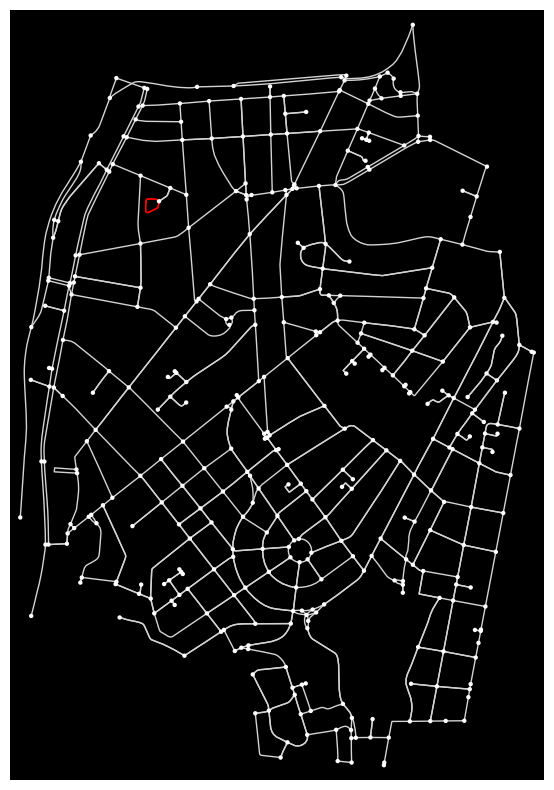

In [11]:
# Identificar as arestas que são self-loops
self_loops = [(u, v) for u, v, k in grafo_rede_viaria.edges(keys=True) if u == v]
print("Self-loops encontrados:", self_loops)

# Configurar as cores das arestas com base na presença de self-loops
ec = []
for u, v, k in grafo_rede_viaria.edges(keys=True):
    if (u, v) in self_loops:
        ec.append("red")  # Colorir os self-loops em vermelho
    else:
        ec.append("lightgray")  # Outras arestas em cinza claro

# Plotar o grafo destacando os self-loops
fig, ax = ox.plot_graph(
    grafo_rede_viaria,
    edge_color=ec,
    edge_linewidth=1,
    node_size=10,
    node_color="white",
    bgcolor="black",
    figsize=(10, 10)
)

plt.show()

Temos apenas um self-loop (em vermelho na imagem acima). Vamos criar uma plotagem com um maior nível de zoom.

Nó com self-loop: 4293878928


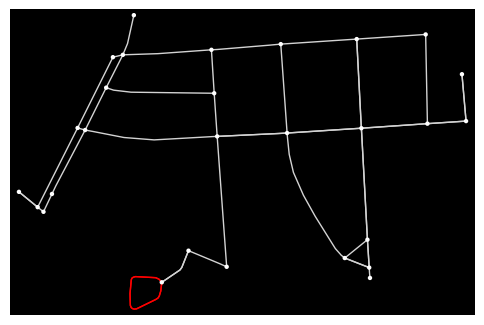

In [12]:
# Selecionar o nó com self-loop
self_loop_node = self_loops[0][0] 
print(f"Nó com self-loop: {self_loop_node}")

# Extrair sub-rede em torno do nó com self-loop (por exemplo, dentro de 800 metros)
subgraph = ego_graph(grafo_rede_viaria, self_loop_node, radius=800, distance="length")

# Configurar as cores das arestas na sub-rede
ec = [
    "red" if u == v else "lightgray"
    for u, v, k in subgraph.edges(keys=True)
]

# Plotar a sub-rede destacando o self-loop
fig, ax = ox.plot_graph(
    subgraph,
    edge_color=ec,
    edge_linewidth=1,
    node_size=10,
    node_color="white",
    bgcolor="black",
    figsize=(6, 6)
)

plt.show()

### 3.2.2 Estatísticas Geométricas

Essas métricas analisam os comprimentos de ruas e segmentos, fornecendo informações sobre a fragmentação e continuidade da rede viária.

- **`edge_length_total`**: Comprimento total de todas as arestas em metros.
- **`edge_length_avg`**: Comprimento médio das arestas em metros.
- **`street_length_total`**: Comprimento total de todas as ruas.
- **`street_segment_count`**: Número total de segmentos de rua.
- **`street_length_avg`**: Comprimento médio dos segmentos de rua.


A partir dessas estatísticas geométricas, podemos tirar algumas conclusões sobre a estrutura e a conectividade da rede viária:


O comprimento total das arestas é de aproximadamente 82,2 km, enquanto o comprimento total das ruas é de 56,3 km. A diferença entre esses valores indica que, embora o comprimento total de todos os segmentos de rua (arestas) seja significativo, a rede em si (considerando ruas exclusivas, sem duplicações de sentido) possui uma extensão um pouco menor. Esse valor reflete uma infraestrutura urbana extensa e conectada, capaz de suportar um tráfego considerável.

O comprimento médio das arestas é de 98,17 metros, enquanto o comprimento médio dos segmentos de rua é ligeiramente maior, com 99,7 metros. Esses valores médios indicam que a maioria dos blocos ou quarteirões na rede é relativamente curta. Essa configuração permite múltiplas interseções e oportunidades de mudança de rota.

O número total de segmentos de rua é 564, o que sugere que a rede é fragmentada em pequenas seções, permitindo a formação de múltiplos blocos e interseções em uma área relativamente compacta. Uma rede com muitos segmentos curtos geralmente promove a acessibilidade e a mobilidade, pois oferece mais opções de rota e facilita o tráfego.







### 3.2.3 Estatísticas Combinadas

As estatísticas combinadas (topológicas e geométricas) fornecem uma visão geral sobre a estrutura e a conectividade da rede viária, combinando aspectos relacionados à organização espacial com medidas estruturais mais abstratas.


- **`circuity_avg`**: Circuidade média da rede, que avalia a relação entre o comprimento real e a distância em linha reta das ruas.
- **`node_density_km`**: Densidade de nós por quilômetro quadrado.
- **`intersection_density_km`**: Densidade de interseções por quilômetro quadrado.
- **`edge_density_km`**: Densidade de arestas por quilômetro quadrado.
- **`street_density_km`**: Densidade de ruas por quilômetro quadrado.



A circuidade média da rede é de 1.025, indicando que, em média, a distância percorrida nas ruas é apenas 2,5% maior que a distância em linha reta entre os pontos conectados. Isso sugere que a rede viária é bastante eficiente em termos de alinhamento, com ruas relativamente diretas e poucas curvas excessivas ou desvios significativos.

A densidade de nós é de aproximadamente 110 nós por km², representando a frequência de pontos de conexão (interseções ou extremidades) na área estudada. Isso reflete uma rede moderadamente densa, característica de áreas urbanas bem desenvolvidas, onde interseções são frequentes.

A densidade de interseções* é de cerca de 95 por km², indicando que a maioria dos nós na rede são interseções e não apenas extremidades de ruas. Essa proporção alta de interseções reforça a ideia de uma rede altamente conectada, permitindo múltiplos caminhos alternativos e maior flexibilidade de mobilidade.

A densidade de arestas (ou densidade de ruas) é de 22,6 km de ruas por km². Isso representa a quantidade total de segmentos de rua disponíveis na área estudada, considerando todas as direções e conexões. Esse valor reflete uma rede densa em termos de infraestrutura viária.

A densidade de ruas exclusivas é de 15,5 km por km². Essa métrica considera cada rua apenas uma vez, independentemente de seu sentido, e mostra o comprimento total de ruas distintas na área. O valor é menor que a densidade de arestas, como esperado, pois ruas bidirecionais e múltiplas conexões aumentam o número total de segmentos, mas não o número de ruas únicas.


As métricas de conectividade por tipo de interseção oferecem uma análise detalhada sobre a complexidade e a densidade da rede viária, evidenciando padrões estruturais e características específicas do sistema de ruas.

A análise revela que a maioria das interseções (61,9%) possuem três ruas conectadas, totalizando 247 interseções desse tipo. Esse padrão é comum em redes urbanas, especialmente em áreas com ruas formando ângulos em “T”, típicos de bairros residenciais. Essa configuração reflete um layout estruturado em blocos ou quarteirões.

A segunda maior proporção (22,8%) corresponde a interseções de quatro vias, abrangendo 91 nós. Essas interseções são características de layouts de grade, onde ruas se cruzam perpendicularmente. E

Além disso, cerca de 13,5% dos nós (54 no total) têm apenas uma conexão, indicando que são extremidades ou pontos de término de ruas. Esses nós estão frequentemente localizados em ruas sem saída ou em regiões menos conectadas da rede, como áreas periféricas ou limites de bairros, onde a continuidade do fluxo é limitada.

A rede também apresenta interseções mais complexas, como as de cinco vias (5-way) e seis vias (6-way), embora essas sejam raras, com apenas cinco e uma interseção, respectivamente. Esses nós geralmente são encontrados em pontos estratégicos da rede, como grandes cruzamentos ou áreas de alta densidade de tráfego.




## 3.3 Indicadores de Conectividade

Embora as estatísticas básicas ofereçam um panorama geral e descritivo da rede, abrangendo informações estruturais simples, como o número de nós, a densidade de ruas, o comprimento total das arestas e a distribuição de interseções, elas são mais adequadas para caracterizar a estrutura geral da rede. Essas métricas são permitem entender a organização básica, mas têm limitações quando se trata de explorar aspectos específicos da conectividade ou o comportamento funcional da rede.

Por outro lado, os indicadores de conectividade vão além da estrutura, focando em análises mais específicas e funcionais. Eles são métricas que medem o nível de interligação entre os elementos de uma rede, fornecendo uma visão quantitativa sobre sua estrutura, eficiência e resiliência. Eles ajudam a identificar padrões de conectividade entre os nós (pontos de interseção) e as arestas (conexões), permitindo entender o funcionamento da rede e sua resposta a diferentes demandas ou falhas.

Em redes espaciais, como redes viárias, de transporte ou de distribuição, esses indicadores são indispensáveis para identificar padrões estruturais, analisar a acessibilidade entre diferentes partes da rede e avaliar a eficiência de deslocamento. Além disso, eles ajudam a localizar pontos críticos, áreas de baixa conectividade e hubs, fornecendo informações que podem auxiliar no planejamento e na gestão da rede.

Nesta análise, calcularemos indicadores como a densidade da rede, o grau dos nós, a assortatividade de grau e as eficiências global e local médias. Esses parâmetros proporcionarão uma visão detalhada e abrangente da conectividade da rede, permitindo identificar padrões, avaliar sua eficiência e destacar características importantes de sua organização estrutural.



### 3.3.1 Densidade da rede

A densidade da rede é uma métrica específica que mede o nível de conectividade relativa da estrutura da rede, enquanto as densidades espaciais (`node_density_km`, etc.) refletem a concentração de componentes viários por área. Portanto, a **densidade da rede** calculada com `nx.density` é uma métrica complementar e oferece uma perspectiva diferente sobre a conectividade geral da rede.

Na biblioteca OSMnx, a função `nx.density` calcula a densidade da rede como a razão entre o número de arestas existentes e o número máximo de arestas possíveis em uma rede totalmente conectada. Em termos práticos:

- A densidade varia entre 0 e 1:
  - **Densidade próxima de 1**: indica que a rede está altamente conectada, com a maioria dos nós ligados diretamente uns aos outros (mais comum em redes de pequeno porte).
  - **Densidade baixa**: sugere uma rede esparsa, onde poucos nós estão conectados entre si (típico de redes viárias).

Vamos calcular a densidade da rede viária do bairro da Liberdade.

In [13]:
# Calcular a densidade da rede:
densidade = nx.density(grafo_rede_viaria)
print("Densidade da rede:", densidade)

Densidade da rede: 0.005270714474628783


A densidade de 0,0053 indica que a rede possui uma conectividade relativamente baixa em relação ao número máximo de conexões possíveis. Em termos práticos, isso é comum em redes viárias, pois as ruas normalmente não conectam todos os nós entre si. Essa baixa densidade confirma a ideia de que a rede viária é composta de ruas específicas e interseções controladas, o que permite a circulação de forma estruturada, em vez de uma rede totalmente conectada.





### 3.3.2 Assortatividade de grau

A assortatividade de grau em uma rede mede a tendência de nós com graus semelhantes estarem conectados entre si, funcionando como uma medida de correlação entre os graus dos nós conectados por uma aresta. Em redes viárias, essa métrica indica se interseções com muitas conexões (alto grau) tendem a se conectar a outras interseções igualmente bem conectadas ou, ao contrário, a interseções com poucas conexões.

- **Assortatividade positiva**: Indica que nós com alto grau tendem a se conectar com outros nós de alto grau. Esse padrão é comum em redes sociais.
- **Assortatividade negativa**: Indica que nós de alto grau tendem a se conectar a nós de baixo grau, típico de redes hierárquicas como redes viárias.
- **Assortatividade próxima de zero**: Não há um padrão claro de conexão entre graus altos e baixos.

Vamos agora calcular a assortatividade de grau.

In [14]:
# Calcular a assortatividade de grau
assortatividade_grau = nx.degree_assortativity_coefficient(grafo_rede_viaria)
print("Assortatividade de Grau:", assortatividade_grau)

Assortatividade de Grau: 0.26610364815200793


A assortatividade de grau de aproximadamente 0,27 indica uma assortatividade positiva moderada na rede viária. Isso sugere que interseções com muitas conexões tendem a se conectar a outras interseções também bem conectadas.




### 3.3.3 Grau dos nós

O grau de um nó em uma rede representa o número de conexões (ou arestas) que ele possui com outros nós. Em redes viárias, isso corresponde ao número de ruas que convergem em uma determinada interseção. Essa métrica ajuda a identificar interseções estratégicas, com altos graus representando locais de maior fluxo e conectividade.

Vamos visualizar os graus dos nós com uma coloração específica.

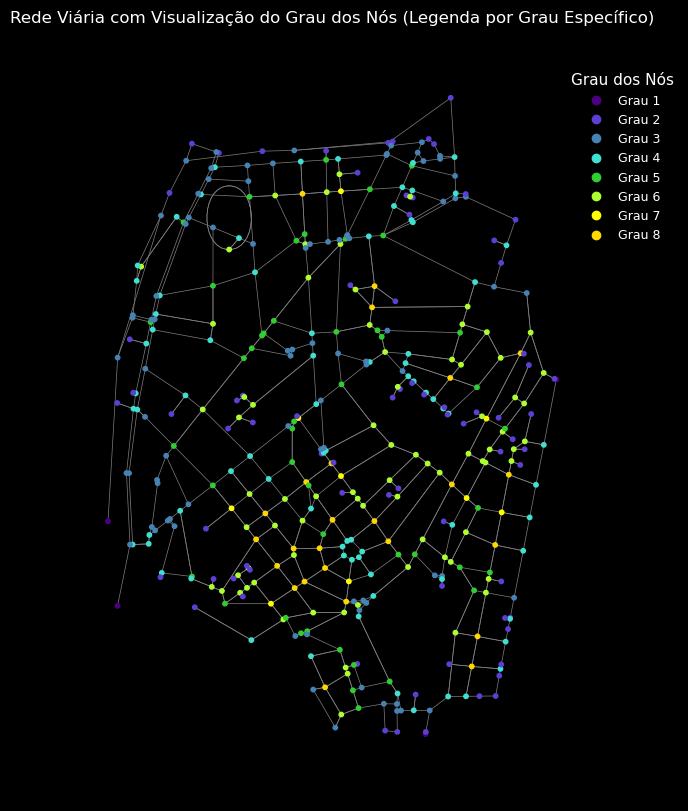

In [15]:
# Definir as cores para cada grau de 1 a 8
colors = ['#4B0082', '#5D3FD3', '#4682B4', '#40E0D0', '#32CD32', '#ADFF2F', '#FFFF00', '#FFD700']

# Obter a posição dos nós do grafo para usar na plotagem
node_positions = {node: (data['x'], data['y']) for node, data in grafo_rede_viaria.nodes(data=True)}

# Obter o grau de cada nó
node_degrees = dict(grafo_rede_viaria.degree())
unique_degrees = sorted(set(node_degrees.values()))  # Graus únicos presentes no grafo

# Mapear os graus para as cores definidas manualmente
node_colors = [colors[min(degree - 1, 7)] for degree in node_degrees.values()]  # Limitar ao índice 7 para graus > 8

# Configurar a figura e o fundo preto
fig, ax = plt.subplots(figsize=(7, 10))
fig.patch.set_facecolor('black')  # Define o fundo da figura como preto
ax.set_facecolor('black')  # Define o fundo do gráfico como preto

# Plotar a rede viária com coloração de grau dos nós
nc = nx.draw_networkx_nodes(
    grafo_rede_viaria, pos=node_positions, node_color=node_colors, node_size=10, ax=ax
)
ec = nx.draw_networkx_edges(grafo_rede_viaria, pos=node_positions, edge_color="gray", width=0.5, ax=ax, arrows=False)

# Criar a legenda personalizada com círculos menores para cada grau presente na rede
legend_elements = [
    mlines.Line2D([], [], color=colors[i], marker='o', linestyle='None', markersize=6, label=f'Grau {i + 1}')
    for i in range(8)  # Criar a legenda para os graus de 1 a 8
]
legend = ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 0.96), title="Grau dos Nós", title_fontsize='11', frameon=False, fontsize='9')
plt.setp(legend.get_texts(), color="white")  # Define a cor do texto da legenda para branco
plt.setp(legend.get_title(), color="white")  # Define a cor do título da legenda para branco

# Adicionar título e exibir o gráfico
plt.title("Rede Viária com Visualização do Grau dos Nós (Legenda por Grau Específico)", color="white")
plt.show()

### 3.3.4 Eficiência global e local

A eficiência global mede como a rede conecta pares de nós de forma eficiente, enquanto a eficiência local avalia a conectividade entre os vizinhos imediatos de cada nó.

In [16]:
# Converter o grafo para não-direcionado
grafo_rede_viaria_nao_direcionado = grafo_rede_viaria.to_undirected()

# Calcular a eficiência global
eficiencia_global = nx.global_efficiency(grafo_rede_viaria_nao_direcionado)
print("Eficiência Global:", eficiencia_global)

# Calcular a eficiência local média
eficiencia_local = nx.local_efficiency(grafo_rede_viaria_nao_direcionado)
print("Eficiência Local Média:", eficiencia_local)

Eficiência Global: 0.11070327841838423
Eficiência Local Média: 0.05547201336675017


No caso do bairro da Liberdade, uma eficiência global de 0,11 sugere que a rede viária não é altamente eficiente para conectar pares de nós de forma direta ou com trajetos curtos. A eficiência local média de 0,055 indica que os vizinhos imediatos não estão bem interconectados, refletindo uma estrutura hierárquica típica de redes viárias urbanas.





## 3.4 Centralidade

Centralidade é um conceito na teoria de redes que busca medir a importância ou influência dos nós em uma rede. Redes são estruturas compostas de nós (ou vértices) conectados por arestas (ou links), e podem representar uma variedade de sistemas: redes sociais (onde os nós são pessoas e as arestas representam amizades ou interações), redes de comunicação (com servidores e conexões), redes biológicas (como proteínas e suas interações), e muito mais. A centralidade fornece uma maneira de quantificar quais nós desempenham papéis de destaque dentro dessas estruturas, revelando quais elementos são mais conectados, acessíveis ou influentes. Em redes viárias, que são compostas por interseções (nós) e ruas (arestas), as medidas de centralidade ajudam a identificar quais interseções são mais conectadas, acessíveis ou críticas para o fluxo de deslocamento.

As métricas de centralidade ajudam a entender a estrutura de uma rede urbana, otimizar o fluxo de tráfego, planejar rotas e identificar áreas centrais ou periféricas em uma cidade.

Existem diferentes tipos de centralidade, cada uma abordando a "importância" de nós e arestas de maneira diferente. Aqui vamos estudar:

- Centralidade de grau;
- Centralidade de proximidade;
- Centralidade de intermediação (betweenness).



### 3.4.1 Centralidade de grau (Degree Centrality)

A centralidade de grau é a maneira mais simples de centralidade, medindo o número de conexões diretas que um nó possui. Em redes sociais, por exemplo, a centralidade de grau indica quantas conexões diretas uma pessoa tem com outras pessoas. Quanto mais conexões, maior o grau de centralidade.

A centralidade de grau é útil para identificar nós altamente conectados, que frequentemente possuem um papel central em redes de colaboração, comércio, redes de comunicação e outras.

Em redes viárias, a centralidade de grau representa o número de ruas que convergem em uma interseção. Quanto maior o grau, mais acessível e importante é essa interseção localmente.

Os grafos obtidos a partir do OSMnx são, por padrão, multigrafos não direcionados, ou seja, permitem múltiplas arestas entre os mesmos pares de nós, mas as informações sobre as direções das vias não estão representadas. Na análise de centralidade, é possível realizar os cálculos tanto considerando quanto ignorando essas direções.

Se a rede viária tiver muitas ruas de mão única, o uso de um multigrafo pode não ser ideal. Isso ocorre porque o multigrafo trata todas as conexões como bidirecionais, o que ignora restrições de direção nas vias e pode distorcer a análise de acessibilidade e navegabilidade. Em redes com muitas ruas de mão única, o uso de um multidigrafo é mais apropriado, pois permite representar a direção real de cada via, capturando com precisão as limitações de direção e refletindo a dinâmica verdadeira do tráfego e da acessibilidade.

Vamos verificar se a rede viária do bairro da liberdade possui muitas vias de mão única.

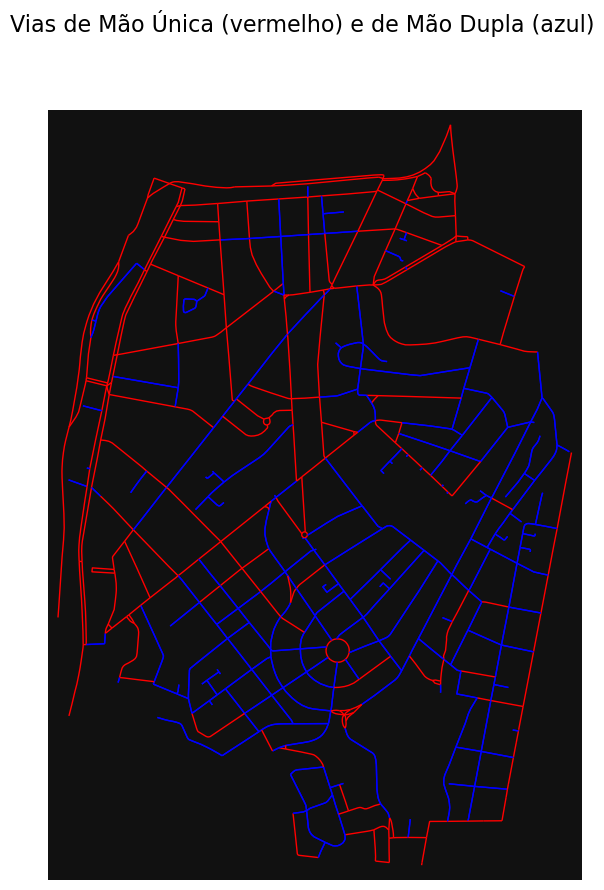

In [17]:
# Configurar as cores das arestas com base no atributo 'mão única'
cores_arestas = ["red" if dados.get('oneway') else "blue" for u, v, dados in grafo_rede_viaria.edges(data=True)]

# Plotar o grafo
fig, ax = ox.plot_graph(
    grafo_rede_viaria,
    edge_color=cores_arestas,
    edge_linewidth=1,
    node_size=0,
    figsize=(10, 10),
    show=False,
    close=False
)

# Adicionar o título
plt.suptitle("Vias de Mão Única (vermelho) e de Mão Dupla (azul)", fontsize=16)
plt.show()

Devido à predominância de ruas de mão única, como mostrado no mapa, é mais apropriado utilizar um multidigrafo para representar a rede viária do bairro da Liberdade. O uso de um multidigrafo permite que as direções das ruas sejam consideradas nas análises, o que proporciona uma visão mais realista e precisa da conectividade e acessibilidade da área. Em redes com muitas vias de mão única, o multidigrafo captura melhor as restrições de direção.

O primeiro passo é converter o `grafo_rede_viaria` para um `MultiDiGraph`, para preservar as direções das vias. Isso garantirá que todas as análises de centralidade, acessibilidade e navegabilidade considerem corretamente as direções.

In [18]:
# Converter o grafo para MultiDiGraph para preservar direções
multidigrafo_rede_viaria = ox.utils_graph.get_digraph(grafo_rede_viaria)

/tmp/ipykernel_26445/2972035766.py:2: FutureWarning: The `get_digraph` function is deprecated and will be removed in the v2.0.0 release. Replace it with `convert.to_digraph` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  multidigrafo_rede_viaria = ox.utils_graph.get_digraph(grafo_rede_viaria)


Agora, calculamos três tipos de centralidade de grau:

- Centralidade de Grau de Entrada: Quantas conexões chegam a cada nó (pontos acessíveis de várias direções).
- Centralidade de Grau de Saída: Quantas conexões saem de cada nó (pontos que podem levar a várias direções).
- Centralidade de Grau Total: A soma do grau de entrada e do grau de saída, representando o total de conexões.

In [19]:
# Calcular as centralidades de grau
centralidade_grau_entrada = nx.in_degree_centrality(multidigrafo_rede_viaria)
centralidade_grau_saida = nx.out_degree_centrality(multidigrafo_rede_viaria)
centralidade_grau_total = nx.degree_centrality(multidigrafo_rede_viaria)

Após calcular as centralidades, atribuímos esses valores como atributos dos nós. Isso facilita a visualização e a análise.

In [20]:
# Atribuir as centralidades como atributos dos nós
nx.set_node_attributes(grafo_rede_viaria, centralidade_grau_entrada, 'centralidade_grau_entrada')
nx.set_node_attributes(grafo_rede_viaria, centralidade_grau_saida, 'centralidade_grau_saida')
nx.set_node_attributes(grafo_rede_viaria, centralidade_grau_total, 'centralidade_grau_total')

Cada tipo de centralidade é armazenado como um atributo dos nós, facilitando o acesso e visualização no grafo. Vamos consultar os atributos de `grafo_rede_viaria` para verificar se esses atributos foram adicionados corretamente ao grafo.

In [21]:
# Obter os nomes dos atributos do primeiro nó como exemplo
atributos_nos = list(next(iter(grafo_rede_viaria.nodes(data=True)))[1].keys())
print("Atributos dos Nós:", atributos_nos)

Atributos dos Nós: ['y', 'x', 'street_count', 'centralidade_grau_entrada', 'centralidade_grau_saida', 'centralidade_grau_total']


Para facilitar a manipulação dos registros, iremos criar um dataframe para armazenar os valores de centralidade de grau de cada nó.

In [22]:
# Criar um DataFrame para armazenar os valores de centralidade
centralidade_grau_df = pd.DataFrame({
    "grau_entrada": centralidade_grau_entrada,
    "grau_saida": centralidade_grau_saida,
    "grau_total": centralidade_grau_total
})

Vamos visualizar os cinco primeiros registros do dataframe criado.

In [23]:
# Exibir os primeiros registros do DataFrame
print(centralidade_grau_df.head())

          grau_entrada  grau_saida  grau_total
587993        0.002513    0.002513    0.005025
25929414      0.005025    0.002513    0.007538
25947658      0.002513    0.005025    0.007538
60609803      0.002513    0.000000    0.002513
60641188      0.005025    0.007538    0.012563


Antes de visualizar a centralidade de grau dos nós, ajustamos o tamanho deles para refletir melhor suas centralidades no gráfico.

In [24]:
# Ajustar os tamanhos dos nós para a visualização
centralidade_grau_df["tamanho_nos_entrada"] = centralidade_grau_df["grau_entrada"] * 2500
centralidade_grau_df["tamanho_nos_saida"] = centralidade_grau_df["grau_saida"] * 2500
centralidade_grau_df["tamanho_nos_total"] = centralidade_grau_df["grau_total"] * 1500

Por fim, vamos plotar os nós na rede viária, ressaltando o valor da centralidade de grau.

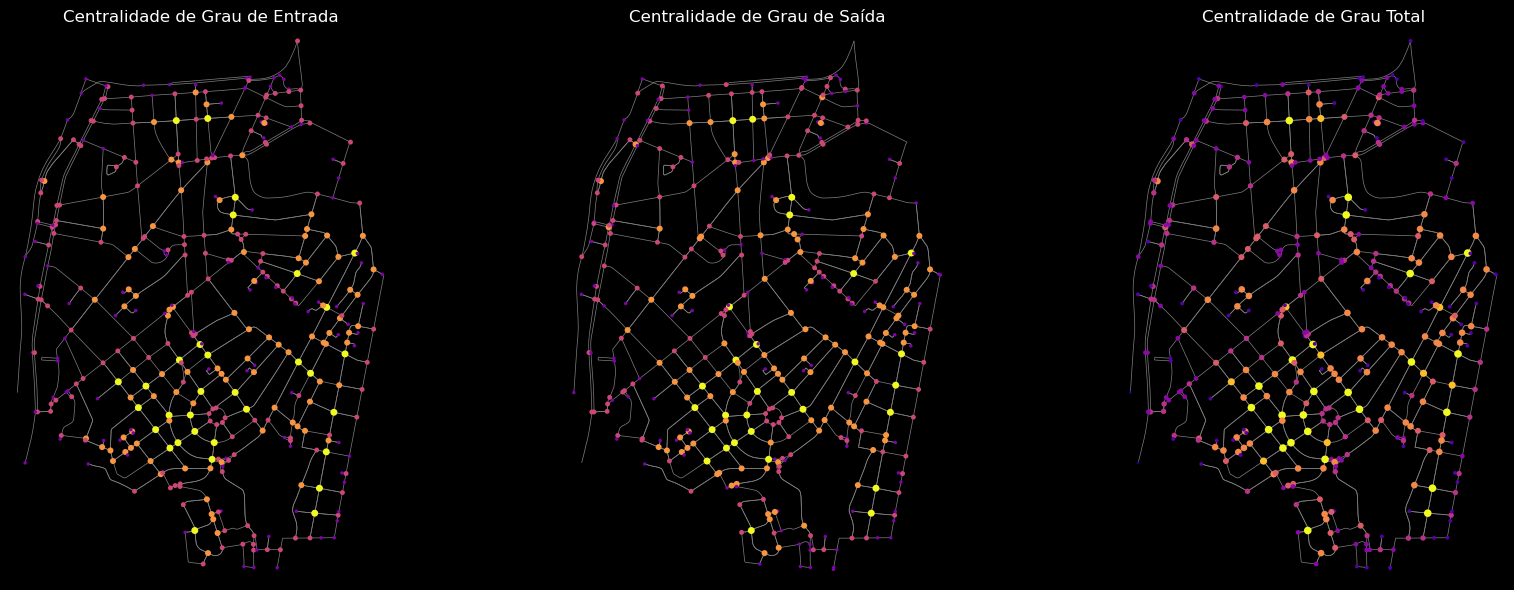

In [25]:
# Plotar as centralidades de grau
fig, eixos = plt.subplots(1, 3, figsize=(18, 6))
fig.patch.set_facecolor('black')
plt.subplots_adjust(wspace=0.1)

# Centralidade de Grau de Entrada
eixo = eixos[0]
eixo.set_facecolor("black")
cores_nos_entrada = ox.plot.get_node_colors_by_attr(grafo_rede_viaria, "centralidade_grau_entrada", cmap="plasma")
ox.plot_graph(
    grafo_rede_viaria,
    ax=eixo,
    node_size=centralidade_grau_df["tamanho_nos_entrada"].tolist(),
    node_color=cores_nos_entrada,
    edge_linewidth=0.5,
    edge_color="gray",
    show=False,
    close=False
)
eixo.set_title("Centralidade de Grau de Entrada", color="white")

# Centralidade de Grau de Saída
eixo = eixos[1]
eixo.set_facecolor("black")
cores_nos_saida = ox.plot.get_node_colors_by_attr(grafo_rede_viaria, "centralidade_grau_saida", cmap="plasma")
ox.plot_graph(
    grafo_rede_viaria,
    ax=eixo,
    node_size=centralidade_grau_df["tamanho_nos_saida"].tolist(),
    node_color=cores_nos_saida,
    edge_linewidth=0.5,
    edge_color="gray",
    show=False,
    close=False
)
eixo.set_title("Centralidade de Grau de Saída", color="white")

# Centralidade de Grau Total
eixo = eixos[2]


eixo.set_facecolor("black")
cores_nos_total = ox.plot.get_node_colors_by_attr(grafo_rede_viaria, "centralidade_grau_total", cmap="plasma")
ox.plot_graph(
    grafo_rede_viaria,
    ax=eixo,
    node_size=centralidade_grau_df["tamanho_nos_total"].tolist(),
    node_color=cores_nos_total,
    edge_linewidth=0.5,
    edge_color="gray",
    show=False,
    close=False
)
eixo.set_title("Centralidade de Grau Total", color="white")

plt.tight_layout()
plt.show()

Com base nessa análise visual, será gerado um histograma para examinar a distribuição da centralidade de grau.

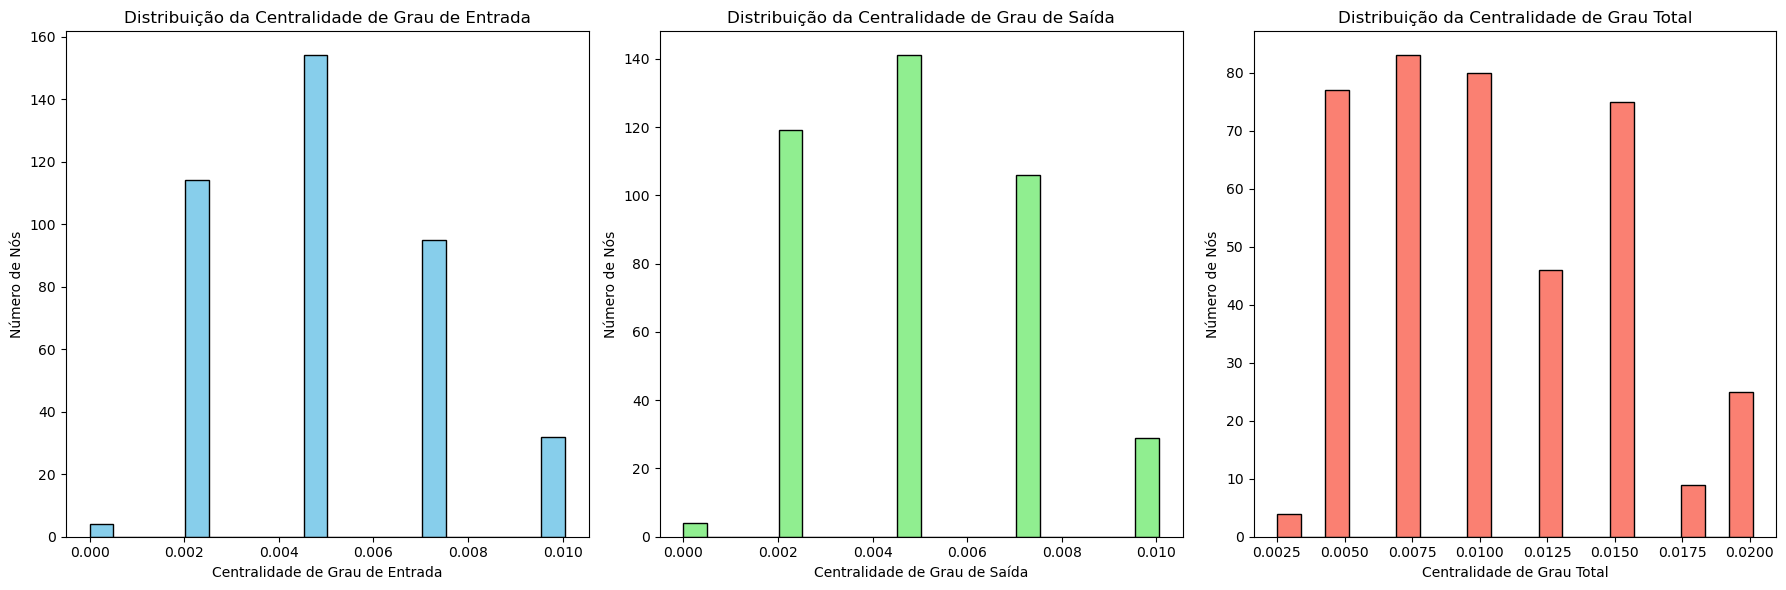

In [26]:
# Plotar os histogramas das centralidades de grau
fig, eixos = plt.subplots(1, 3, figsize=(18, 6))

# Histograma da Centralidade de Grau de Entrada
eixos[0].hist(centralidade_grau_entrada.values(), bins=20, color='skyblue', edgecolor='black')
eixos[0].set_xlabel("Centralidade de Grau de Entrada")
eixos[0].set_ylabel("Número de Nós")
eixos[0].set_title("Distribuição da Centralidade de Grau de Entrada")

# Histograma da Centralidade de Grau de Saída
eixos[1].hist(centralidade_grau_saida.values(), bins=20, color='lightgreen', edgecolor='black')
eixos[1].set_xlabel("Centralidade de Grau de Saída")
eixos[1].set_ylabel("Número de Nós")
eixos[1].set_title("Distribuição da Centralidade de Grau de Saída")

# Histograma da Centralidade de Grau Total
eixos[2].hist(centralidade_grau_total.values(), bins=20, color='salmon', edgecolor='black')
eixos[2].set_xlabel("Centralidade de Grau Total")
eixos[2].set_ylabel("Número de Nós")
eixos[2].set_title("Distribuição da Centralidade de Grau Total")

plt.tight_layout()
plt.show()

O primeiro histograma mostra a distribuição da centralidade de grau de entrada dos nós, ou seja, o número de ruas que chegam a cada ponto da rede. Observamos que a maioria dos nós tem uma centralidade de entrada baixa, concentrada em torno de 0,002 a 0,004. Isso indica que muitos pontos na rede possuem poucas conexões de entrada, provavelmente representando interseções simples ou extremidades da rede. Apenas alguns nós têm centralidade de entrada mais alta, sugerindo que poucos pontos funcionam como interseções principais para o fluxo de chegada.

O segundo histograma representa a centralidade de grau de saída, ou seja, o número de ruas que saem de cada nó. A distribuição é similar à centralidade de entrada, com a maioria dos nós apresentando valores de centralidade de saída baixos, em torno de 0,002 a 0,004. Isso indica que a maioria dos nós permite que o tráfego flua para poucas direções. Novamente, apenas alguns nós apresentam um número elevado de saídas, o que sugere que apenas algumas interseções desempenham um papel importante no escoamento do tráfego.

O terceiro histograma mostra a distribuição da centralidade de grau total, que é a soma das centralidades de entrada e saída. Aqui, a distribuição é mais ampla, com um maior número de nós em faixas de centralidade mais altas, alcançando valores em torno de 0,01 a 0,015. Isso indica que alguns nós têm uma alta conectividade geral, seja para entrada ou saída, o que os torna pontos centrais na rede. Esses nós provavelmente representam interseções principais, com alta acessibilidade e importância para a mobilidade geral da rede.

Esses histogramas mostram que a maioria dos nós na rede possui baixa conectividade de entrada e saída, enquanto apenas alguns nós têm alta centralidade, tanto para entrada quanto para saída. Esse padrão sugere uma rede onde alguns pontos específicos (interseções principais) são centrais para a conectividade geral, enquanto a maioria dos nós serve como pontos de conexão menores.





### 3.4.2 Centralidade de proximidade (Closeness Centrality)

A **Centralidade de Proximidade** avalia a proximidade de um nó em relação a todos os outros na rede. Ela mede a acessibilidade de um nó, indicando quão rapidamente ele pode ser alcançado a partir de outros pontos.

Em redes de comunicação, um nó com alta centralidade de proximidade pode ser um ponto eficiente de distribuição de informações, devido ao seu fácil acesso por outros nós. Em redes sociais, pessoas com alta proximidade podem se comunicar rapidamente com qualquer outra pessoa, direta ou indiretamente.

Em redes viárias, interseções com alta centralidade de proximidade são aquelas mais "centrais" e facilmente acessíveis, sugerindo uma posição vantajosa em termos de deslocamento.

Agora, calculamos três tipos de centralidade de proximidade:

- **Centralidade de proximidade de Entrada**: Mede o quão acessível um nó é a partir de outros pontos da rede.
- **Centralidade de proximidade de Saída**: Mede o quão bem um nó conecta a rede a partir dele.
- **Centralidade de proximidade Total**: Combina as centralidades de entrada e saída, representando o total de conexões.

In [27]:
# Calcular a centralidade de proximidade considerando o peso das arestas ('length')

# Centralidade de Proximidade de Entrada (usando .reverse() e peso)
centralidade_proximidade_entrada = nx.closeness_centrality(multidigrafo_rede_viaria.reverse(), distance='length')

# Centralidade de Proximidade de Saída (usando o grafo original e peso)
centralidade_proximidade_saida = nx.closeness_centrality(multidigrafo_rede_viaria, distance='length')

# Centralidade de Proximidade Total (usando .to_undirected() e peso)
centralidade_proximidade_total = nx.closeness_centrality(multidigrafo_rede_viaria.to_undirected(), distance='length')

Após calcular as centralidades, atribuímos esses valores como atributos dos nós. Isso facilita a visualização e a análise.

In [28]:
# Atribuir centralidade de proximidade como atributos dos nós
nx.set_node_attributes(grafo_rede_viaria, centralidade_proximidade_entrada, 'centralidade_proximidade_entrada')
nx.set_node_attributes(grafo_rede_viaria, centralidade_proximidade_saida, 'centralidade_proximidade_saida')
nx.set_node_attributes(grafo_rede_viaria, centralidade_proximidade_total, 'centralidade_proximidade_total')

# Obter os nomes dos atributos do primeiro nó como exemplo
atributos_nos = list(next(iter(grafo_rede_viaria.nodes(data=True)))[1].keys())
print("Atributos dos Nós:", atributos_nos)

Atributos dos Nós: ['y', 'x', 'street_count', 'centralidade_grau_entrada', 'centralidade_grau_saida', 'centralidade_grau_total', 'centralidade_proximidade_entrada', 'centralidade_proximidade_saida', 'centralidade_proximidade_total']


Para facilitar a manipulação dos registros, iremos criar um dataframe para armazenar os valores de centralidade de cada nó.

In [29]:
# Criar DataFrame para armazenar as centralidades de proximidade
centralidade_proximidade_df = pd.DataFrame({
    "proximidade_entrada": centralidade_proximidade_entrada,
    "proximidade_saida": centralidade_proximidade_saida,
    "proximidade_total": centralidade_proximidade_total
})

# Exibir os cinco primeiros registros do DataFrame
print(centralidade_proximidade_df.head())

          proximidade_entrada  proximidade_saida  proximidade_total
587993               0.000428           0.000424           0.000548
25929414             0.000410           0.000444           0.000562
25947658             0.000565           0.000409           0.000616
60609803             0.000000           0.000331           0.000571
60641188             0.000539           0.000513           0.000647


Os valores de centralidade de proximidade são baixos porque a métrica leva em conta as distâncias reais entre os nós (no caso, o atributo `length`, que representa a distância física). Em redes viárias, especialmente em áreas urbanas grandes, as distâncias podem ser grandes o suficiente para fazer com que as centralidades de proximidade resultem em valores baixos, uma vez que esta métrica é inversamente proporcional à soma das distâncias até outros nós.

In [30]:
# Ajustar os tamanhos dos nós para a visualização
centralidade_proximidade_df["tamanho_nos_entrada"] = centralidade_proximidade_df["proximidade_entrada"] * 50000
centralidade_proximidade_df["tamanho_nos_saida"] = centralidade_proximidade_df["proximidade_saida"] * 50000
centralidade_proximidade_df["tamanho_nos_total"] = centralidade_proximidade_df["proximidade_total"] * 50000

Por fim, vamos plotar os nós na rede viária, ressaltando o valor da centralidade de proximidade.

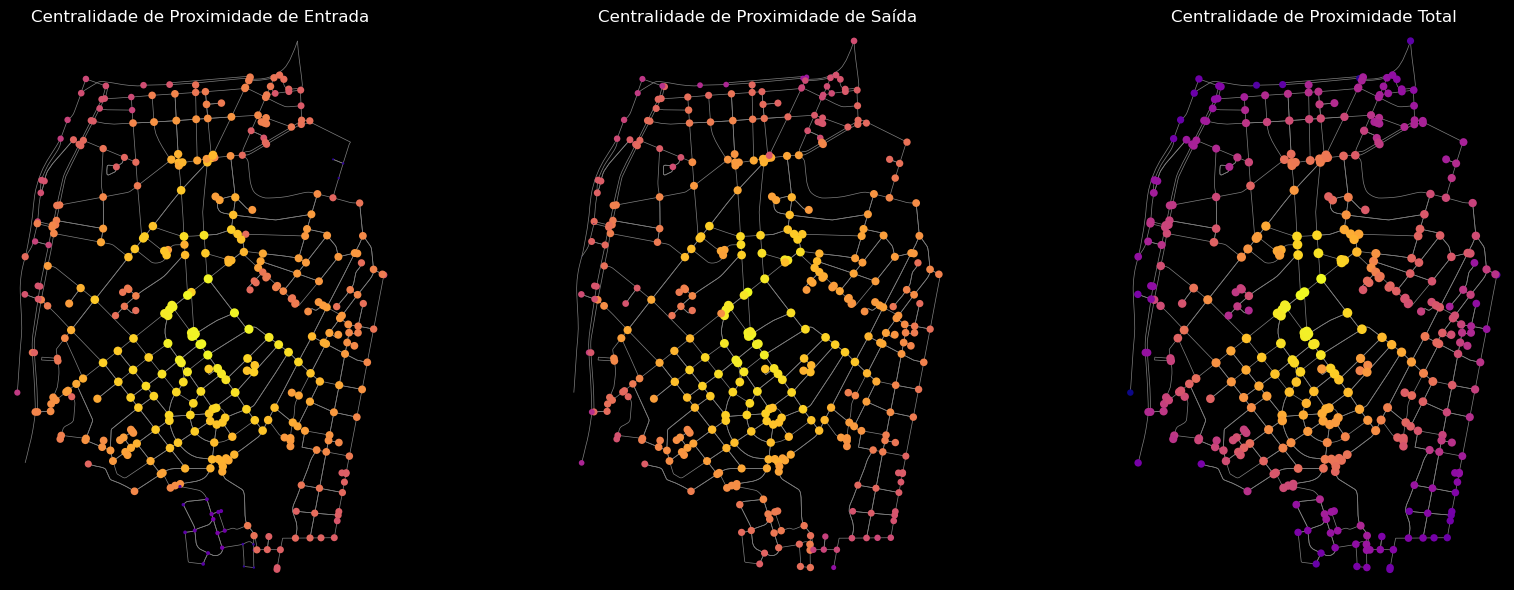

In [31]:
# Configurar a figura para 3 gráficos em linha com fundo preto
fig, eixos = plt.subplots(1, 3, figsize=(18, 6))
fig.patch.set_facecolor('black')

# Ajustar o espaçamento entre os gráficos
plt.subplots_adjust(wspace=0.1)

# Plotar Centralidade de Proximidade de Entrada com fundo preto
eixo = eixos[0]
eixo.set_facecolor("black")
cores_nos_entrada = ox.plot.get_node_colors_by_attr(grafo_rede_viaria, "centralidade_proximidade_entrada", cmap="plasma")
ox.plot_graph(
    grafo_rede_viaria,
    ax=eixo,
    node_size=centralidade_proximidade_df["tamanho_nos_entrada"].tolist(),
    node_color=cores_nos_entrada,
    node_zorder=2,
    edge_linewidth=0.5,
    edge_color="gray",
    show=False,
    close=False
)
eixo.set_title("Centralidade de Proximidade de Entrada", color="white")

# Plotar Centralidade de Proximidade de Saída com fundo preto
eixo = eixos[1]
eixo.set_facecolor("black")
cores_nos_saida = ox.plot.get_node_colors_by_attr(grafo_rede_viaria, "centralidade_proximidade_saida", cmap="plasma")
ox.plot_graph(
    grafo_rede_viaria,
    ax=eixo,
    node_size=centralidade_proximidade_df["tamanho_nos_saida"].tolist(),
    node_color=cores_nos_saida,
    node_zorder=2,
    edge_linewidth=0.5,
    edge_color="gray",
    show=False,
    close=False
)
eixo.set_title("Centralidade de Proximidade de Saída", color="white")

# Plotar Centralidade de Proximidade Total com fundo preto
eixo = eixos[2]
eixo.set_facecolor("black")
cores_nos_total = ox.plot.get_node_colors_by_attr(grafo_rede_viaria, "centralidade_proximidade_total", cmap="plasma")
ox.plot_graph(
    grafo_rede_viaria,
    ax=eixo,
    node_size=centralidade_proximidade_df["tamanho_nos_total"].tolist(),
    node_color=cores_nos_total,
    node_zorder=2,
    edge_linewidth=0.5,
    edge_color="gray",
    show=False,
    close=False
)
eixo.set_title("Centralidade de Proximidade Total", color="white")

plt.tight_layout()
plt.show()

Com base nessa análise visual, será gerado um histograma para examinar a distribuição da centralidade de proximidade entre os nós da rede.

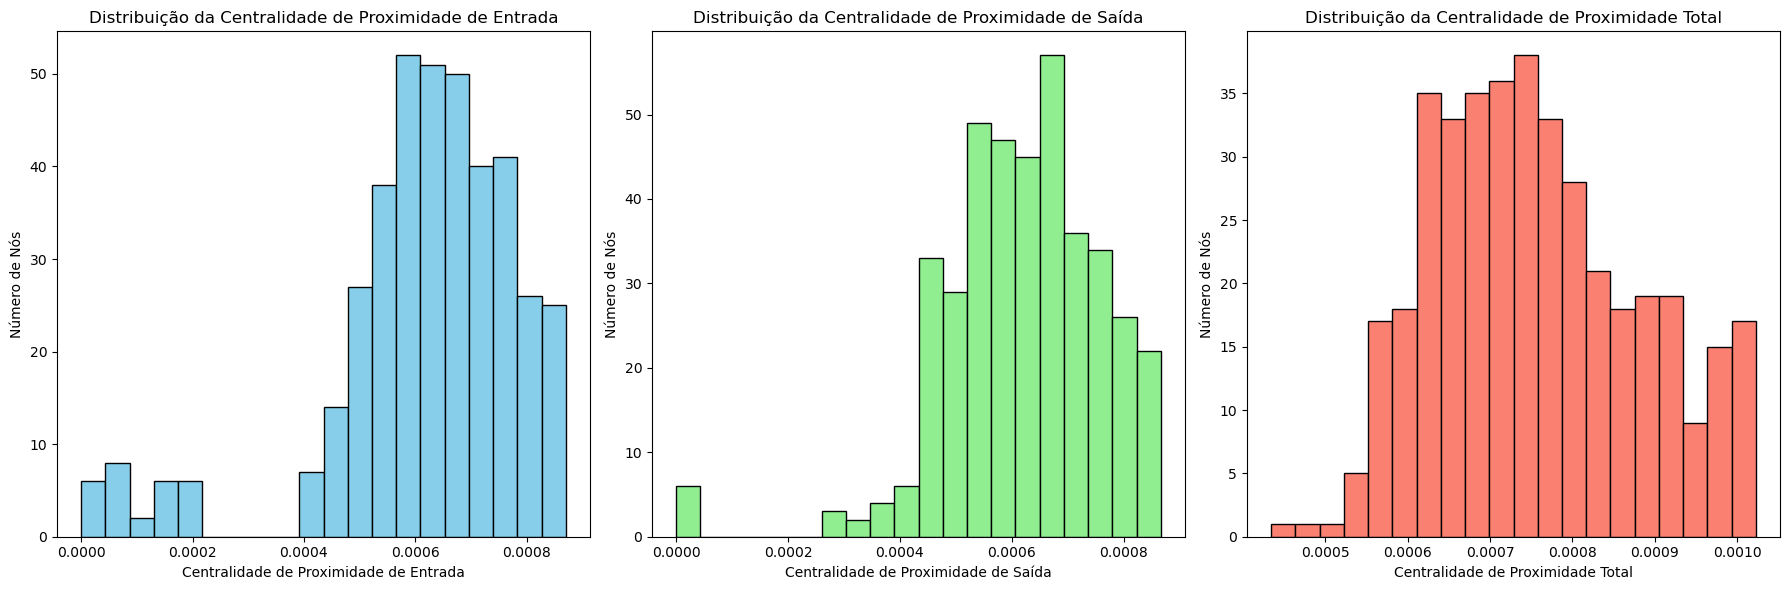

In [32]:
# Plotar os histogramas das centralidades de proximidade
fig, eixos = plt.subplots(1, 3, figsize=(18, 6))

# Histograma da Centralidade de Proximidade de Entrada
eixos[0].hist(centralidade_proximidade_entrada.values(), bins=20, color='skyblue', edgecolor='black')
eixos[0].set_xlabel("Centralidade de Proximidade de Entrada")
eixos[0].set_ylabel("Número de Nós")
eixos[0].set_title("Distribuição da Centralidade de Proximidade de Entrada")

# Histograma da Centralidade de Proximidade de Saída
eixos[1].hist(centralidade_proximidade_saida.values(), bins=20, color='lightgreen', edgecolor='black')
eixos[1].set_xlabel("Centralidade de Proximidade de Saída")
eixos[1].set_ylabel("Número de Nós")
eixos[1].set_title("Distribuição da Centralidade de Proximidade de Saída")

# Histograma da Centralidade de Proximidade Total
eixos[2].hist(centralidade_proximidade_total.values(), bins=20, color='salmon', edgecolor='black')
eixos[2].set_xlabel("Centralidade de Proximidade Total")
eixos[2].set_ylabel("Número de Nós")
eixos[2].set_title("Distribuição da Centralidade de Proximidade Total")

plt.tight_layout()
plt.show()

Vamos interpretar cada um dos histogramas:


*Centralidade de Proximidade de Entrada*

- **Distribuição**: A maioria dos nós apresenta valores de centralidade de proximidade de entrada entre 0.0004 e 0.0008, o que indica que muitos nós podem ser alcançados a partir de outros nós na rede com relativa facilidade (em termos de caminhos curtos ponderados).
- **Nós com valor próximo de zero**: Há alguns nós com valores muito baixos (próximos de 0), sugerindo que esses nós são menos acessíveis ou mais isolados para serem alcançados de outras partes da rede. Esses podem representar extremidades ou pontos periféricos.
- **Pico na distribuição**: O pico na faixa de 0.0006 a 0.0008 indica que a maior parte dos nós tem uma acessibilidade de entrada moderada, tornando-os relativamente bem conectados na rede em termos de proximidade.

*Centralidade de Proximidade de Saída*

- **Distribuição**: A centralidade de proximidade de saída mostra uma distribuição similar, com a maioria dos valores concentrados entre 0.0004 e 0.0008. Isso indica que muitos nós têm uma conectividade de saída moderada, permitindo o acesso a outros nós na rede em caminhos curtos.
- **Nós com valores muito baixos**: Assim como na centralidade de entrada, alguns nós apresentam valores baixos próximos de zero, indicando que eles fornecem pouca acessibilidade para outras partes da rede. Esses nós podem estar em áreas periféricas ou representar pontos menos centrais em termos de saída.
- **Pico**: O pico está entre 0.0006 e 0.0008, sugerindo que a rede tem uma estrutura onde muitos nós estão moderadamente conectados para acesso de saída.

*Centralidade de Proximidade Total*

- **Distribuição**: A centralidade de proximidade total apresenta uma distribuição mais concentrada entre 0.0005 e 0.0010, com um pico entre 0.0006 e 0.0008.
- **Valores próximos a zero**: Existem poucos nós com centralidade de proximidade total muito baixa, indicando que a maioria dos nós tem uma acessibilidade geral razoável (considerando tanto entrada quanto saída).
- **Interpretação Geral**: A centralidade total fornece uma visão mais equilibrada da proximidade dos nós, sugerindo que a rede é relativamente bem conectada em termos de proximidade geral. A faixa mais concentrada na região central do histograma indica uma distribuição relativamente uniforme de acessibilidade na rede.


Esses histogramas indicam que a maioria dos nós na rede viária possui uma acessibilidade moderada, tanto para entrada quanto para saída, o que resulta em uma centralidade de proximidade total similar para muitos nós. Essa distribuição sugere uma rede onde a maioria dos pontos é razoavelmente acessível e conectada, mas existem alguns nós com acessibilidade reduzida, provavelmente em regiões periféricas ou de baixa conectividade.

A análise da centralidade de proximidade ajuda a entender quais nós estão mais "centralmente" localizados em termos de facilidade de acesso, sendo que a maioria parece estar bem conectada, com alguns nós periféricos e menos acessíveis.




### 3.4.3 Centralidade de intermediação (Betweenness Centrality)

A centralidade de intermediação mede quantas vezes um nó está presente nos caminhos mais curtos entre pares de nós na rede. Ela avalia o papel de um nó como "ponte" ou intermediário, facilitando o fluxo ou a comunicação entre diferentes partes da rede.

A centralidade de intermediação difere da centralidade de grau e da centralidade de proximidade em sua abrangência e foco analítico. Enquanto as centralidades de grau e proximidade são mais locais ou quase-locais, a centralidade de intermediação tem um caráter global, avaliando o papel do nó em toda a estrutura da rede.

Em redes viárias, a centralidade de intermediação ajuda a identificar interseções importantes que funcionam como pontos críticos de passagem. Esses nós são fundamentais para a conectividade global, pois sustentam o fluxo entre diferentes partes da rede. Incorporar o comprimento das ruas como peso torna a métrica mais alinhada com a realidade física, priorizando caminhos que minimizam a distância total. Isso é crucial para análises de mobilidade e acessibilidade.

In [33]:
# Calcular a centralidade de intermediação com base no comprimento das ruas ('length')
centralidade_intermediacao = nx.betweenness_centrality(multidigrafo_rede_viaria, weight='length')

# Exibir os valores calculados
print(centralidade_intermediacao)

# Atribuir os valores como atributos dos nós no grafo
nx.set_node_attributes(grafo_rede_viaria, centralidade_intermediacao, 'centralidade_intermediacao')

# Obter os nomes dos atributos dos nós como exemplo
atributos_nos = list(next(iter(grafo_rede_viaria.nodes(data=True)))[1].keys())
print("Atributos dos Nós:", atributos_nos)

{587993: 0.020657443388225765, 25929414: 0.020524537042897105, 25947658: 0.023315570294798933, 60609803: 0.0, 60641188: 0.05279546346341278, 60641336: 0.0, 60641341: 0.014860195182461426, 60641427: 0.010056580129868486, 60641430: 0.006493424300343025, 60641438: 0.003164436793539486, 60641444: 0.009721149829753301, 60685370: 0.007809830006455451, 85723130: 0.08173107350353784, 85723131: 0.099293697707682, 85728632: 0.019360024302874576, 132347429: 0.01108185765097528, 132347430: 0.011214763996303938, 133491023: 0.00016455071326405328, 172004065: 0.017695530549472805, 172004067: 0.06102299912661545, 172004069: 0.06875688265002596, 172004070: 0.06587091629431795, 172008334: 0.052124602863182413, 176017405: 0.030682379150158857, 176019578: 0.028771059326861005, 176019579: 0.08641443995797628, 176020582: 0.05183347467817678, 176020585: 0.09481918408161716, 176020912: 0.062396364695011586, 176021082: 0.04981456400389859, 176021768: 0.06925053478981812, 246650787: 0.04516917079098262, 2466507

Para facilitar a manipulação dos registros, criamos um dataframe para armazenar os valores de centralidade de intermediação.

In [34]:
# Criar um DataFrame para armazenar os valores de centralidade de intermediação
centralidade_intermediacao_df = pd.DataFrame({
    "centralidade_intermediacao": centralidade_intermediacao
})

# Exibir os cinco primeiros registros do DataFrame
print(centralidade_intermediacao_df.head())

          centralidade_intermediacao
587993                      0.020657
25929414                    0.020525
25947658                    0.023316
60609803                    0.000000
60641188                    0.052795


Por fim, vamos plotar os nós na rede viária, ressaltando o valor da centralidade de intermediação.

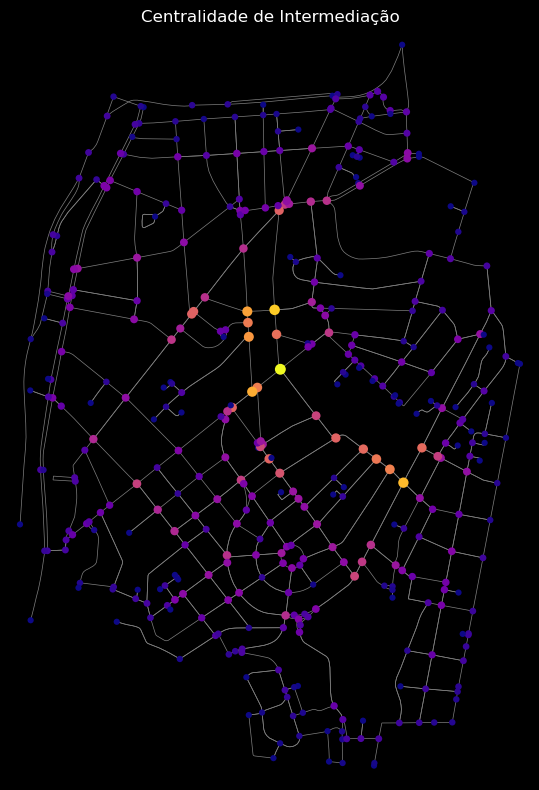

In [35]:
# Visualizar os nós na rede viária com base na centralidade de intermediação
import matplotlib.pyplot as plt
import osmnx as ox

# Configurar a figura para um único gráfico com fundo preto
fig, ax = plt.subplots(figsize=(10, 8))
fig.patch.set_facecolor('black')  # Fundo preto para a figura
ax.set_facecolor("black")  # Fundo preto para o gráfico

# Gerar as cores dos nós com base na centralidade de intermediação
cores_intermediacao = ox.plot.get_node_colors_by_attr(grafo_rede_viaria, "centralidade_intermediacao", cmap="plasma")

# Ajustar os tamanhos dos nós para torná-los mais visíveis
tamanhos_nos = [20 + 200 * valor for valor in centralidade_intermediacao_df["centralidade_intermediacao"]]

# Plotar o grafo com a centralidade de intermediação
ox.plot_graph(
    grafo_rede_viaria,
    ax=ax,
    node_size=tamanhos_nos,
    node_color=cores_intermediacao,
    node_zorder=2,
    edge_linewidth=0.5,
    edge_color="gray",
    show=False,
    close=False
)

# Adicionar título e exibir o gráfico
ax.set_title("Centralidade de Intermediação", color="white")
plt.tight_layout()
plt.show()

A centralidade de intermediação mede a importância de um nó como ponto de passagem nos caminhos mais curtos entre pares de nós. Nós com alta centralidade (tons quentes como amarelo e laranja) desempenham papéis importantes como pontos de passagem na rede, localizados em áreas de maior fluxo. Já os nós com baixa centralidade (tons frios como azul e roxo) são menos utilizados como pontos de passagem, geralmente localizados nas extremidades da rede ou em áreas menos conectadas.

Com base nessa análise visual, geramos um histograma para examinar a distribuição da centralidade de intermediação.

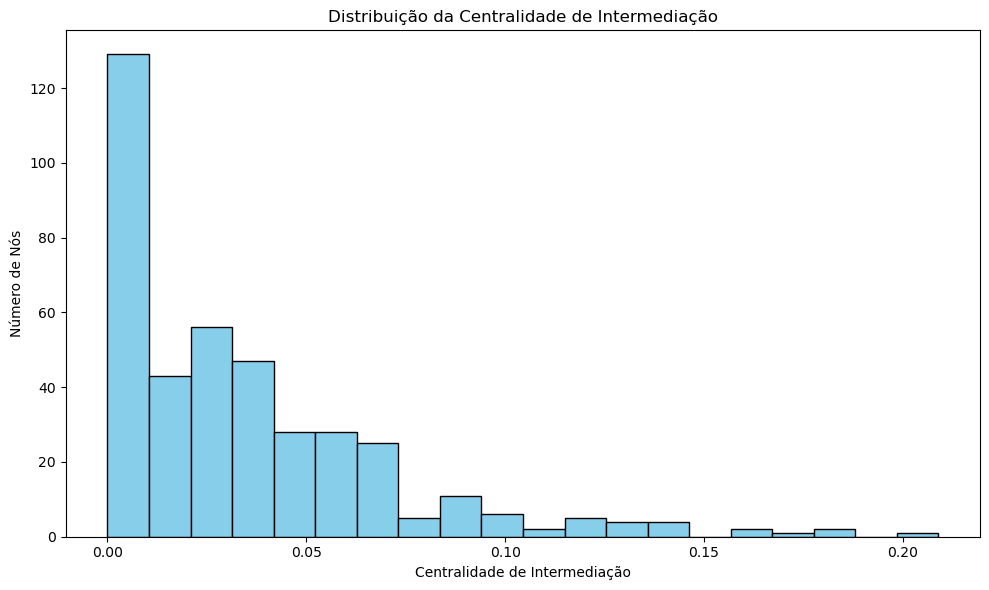

In [36]:
# Plotar o histograma da centralidade de intermediação
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(centralidade_intermediacao.values(), bins=20, color='skyblue', edgecolor='black')
ax.set_xlabel("Centralidade de Intermediação")
ax.set_ylabel("Número de Nós")
ax.set_title("Distribuição da Centralidade de Intermediação")
plt.tight_layout()
plt.show()

O histograma da centralidade de intermediação mostra a distribuição dos nós na rede viária de acordo com sua importância para o fluxo de caminhos mais curtos. A centralidade de intermediação mede quantas vezes um nó atua como ponto de passagem em rotas entre pares de outros nós, indicando sua relevância na conectividade da rede.

A análise do histograma revela que a maioria dos nós possui valores de centralidade de intermediação próximos de zero, conforme evidenciado pela alta concentração de nós na extremidade esquerda do gráfico. Isso sugere que grande parte dos nós tem pouca ou nenhuma importância como pontos de passagem em rotas mais curtas, provavelmente por serem interseções simples ou terminais que não desempenham um papel estratégico no fluxo geral da rede.

Conforme os valores de centralidade aumentam, a frequência de nós diminui rapidamente, havendo uma quantidade pequena de nós com centralidade em torno de 0,05 e um número ainda menor com valores entre 0,1 e 0,2. Isso indica que apenas alguns nós atuam como pontos de passagem significativos, conectando diferentes partes da rede.

Finalmente, observa-se que existem alguns poucos nós com valores de centralidade de intermediação mais altos, próximos de 0,2. Esses nós provavelmente representam interseções principais ou rotas centrais onde muitos caminhos mais curtos passam, tornando-os cruciais para a conectividade e fluidez do tráfego na rede.

Em resumo, o padrão observado sugere uma estrutura hierárquica na rede viária, onde a maioria dos nós apresenta baixa importância para o fluxo de caminhos mais curtos, enquanto um número reduzido de nós atua como pontos centrais, suportando a maior parte da intermediação na rede. Esses nós de alta centralidade de intermediação são importantes para o fluxo e devem ser considerados em análises de acessibilidade e mobilidade, pois interrupções neles podem impactar significativamente a conectividade da rede.



Após realizar a análise individual das centralidades de grau, proximidade e intermediação, agora iremos criar um gráfico consolidando as três métricas (grau total, proximidade total e intermediação). Esse plot permitirá uma visão mais ampla e comparativa, facilitando a análise geral da conectividade e da importância dos nós na rede viária.

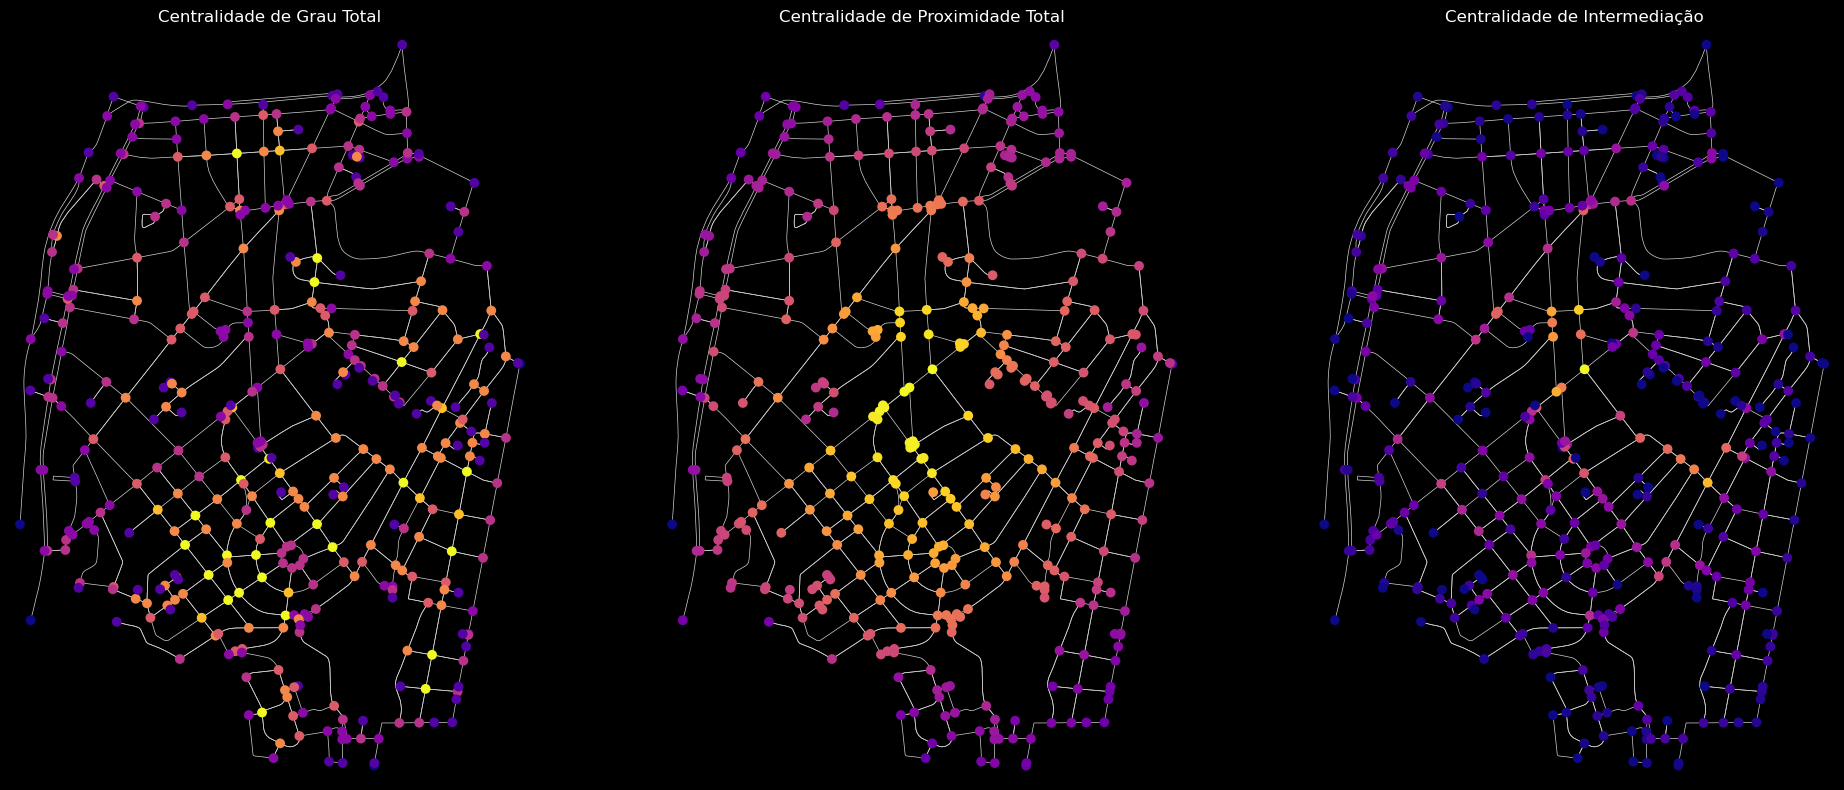

In [37]:
# Configurar a figura com 3 colunas e 1 linha, fundo preto
fig, eixos = plt.subplots(1, 3, figsize=(20, 8), facecolor="black")

# Ajustar o fundo preto para cada eixo
for eixo in eixos:
    eixo.set_facecolor("black")

# Plotar a Centralidade de Grau Total
cores_grau_total = ox.plot.get_node_colors_by_attr(grafo_rede_viaria, "centralidade_grau_total", cmap="plasma")
ox.plot_graph(
    grafo_rede_viaria,
    node_color=cores_grau_total,
    node_size=50,
    edge_linewidth=0.5,
    edge_color="lightgray",
    bgcolor="black",
    ax=eixos[0],
    show=False,
    close=False
)
eixos[0].set_title("Centralidade de Grau Total", color="white")

# Plotar a Centralidade de Proximidade Total
cores_proximidade_total = ox.plot.get_node_colors_by_attr(grafo_rede_viaria, "centralidade_proximidade_total", cmap="plasma")
ox.plot_graph(
    grafo_rede_viaria,
    node_color=cores_proximidade_total,
    node_size=50,
    edge_linewidth=0.5,
    edge_color="lightgray",
    bgcolor="black",
    ax=eixos[1],
    show=False,
    close=False
)
eixos[1].set_title("Centralidade de Proximidade Total", color="white")

# Plotar a Centralidade de Intermediação
cores_intermediacao = ox.plot.get_node_colors_by_attr(grafo_rede_viaria, "centralidade_intermediacao", cmap="plasma")
ox.plot_graph(
    grafo_rede_viaria,
    node_color=cores_intermediacao,
    node_size=50,
    edge_linewidth=0.5,
    edge_color="lightgray",
    bgcolor="black",
    ax=eixos[2],
    show=False,
    close=False
)
eixos[2].set_title("Centralidade de Intermediação", color="white")

# Ajustar o layout e exibir o gráfico
plt.tight_layout()
plt.show()

Cada plot ilustra o papel distinto que os nós desempenham na conectividade e acessibilidade da rede.

O primeiro plot mostra a centralidade de grau total, que mede o número de conexões diretas de cada nó. Nós com maior grau (cores mais claras) correspondem a interseções onde várias ruas convergem, representando pontos centrais de movimentação local. A predominância de nós com grau menor (cores mais escuras) indica que a maioria das interseções conecta apenas algumas ruas, enquanto poucos nós desempenham um papel mais relevante na estrutura geral da rede.

O segundo plot apresenta a centralidade de proximidade total, que reflete a facilidade com que um nó pode alcançar outros pontos da rede. Nós com alta centralidade de proximidade (cores claras) estão posicionados de forma estratégica, permitindo acessar outras áreas da rede com poucas etapas. Já os nós com centralidade mais baixa (cores escuras) estão localizados em áreas periféricas ou menos acessíveis, refletindo sua posição mais afastada do centro da rede.

O terceiro plot exibe a centralidade de intermediação, que mede o quanto um nó é usado como ponto de passagem nos caminhos mais curtos entre outros pares de nós. Nós com alta centralidade de intermediação (cores quentes) são críticos para o fluxo de tráfego, conectando diferentes partes da rede. Esses nós geralmente estão em posições estratégicas, como grandes interseções ou áreas centrais. Por outro lado, nós com baixa centralidade de intermediação (cores frias) têm menor relevância para o fluxo geral, atuando mais como pontos terminais ou locais de menor conectividade global.

Com base nessa análise visual, será gerado um histograma para examinar a distribuição das centtralidades, permitindo uma visão quantitativa complementar ao padrão espacial observado.

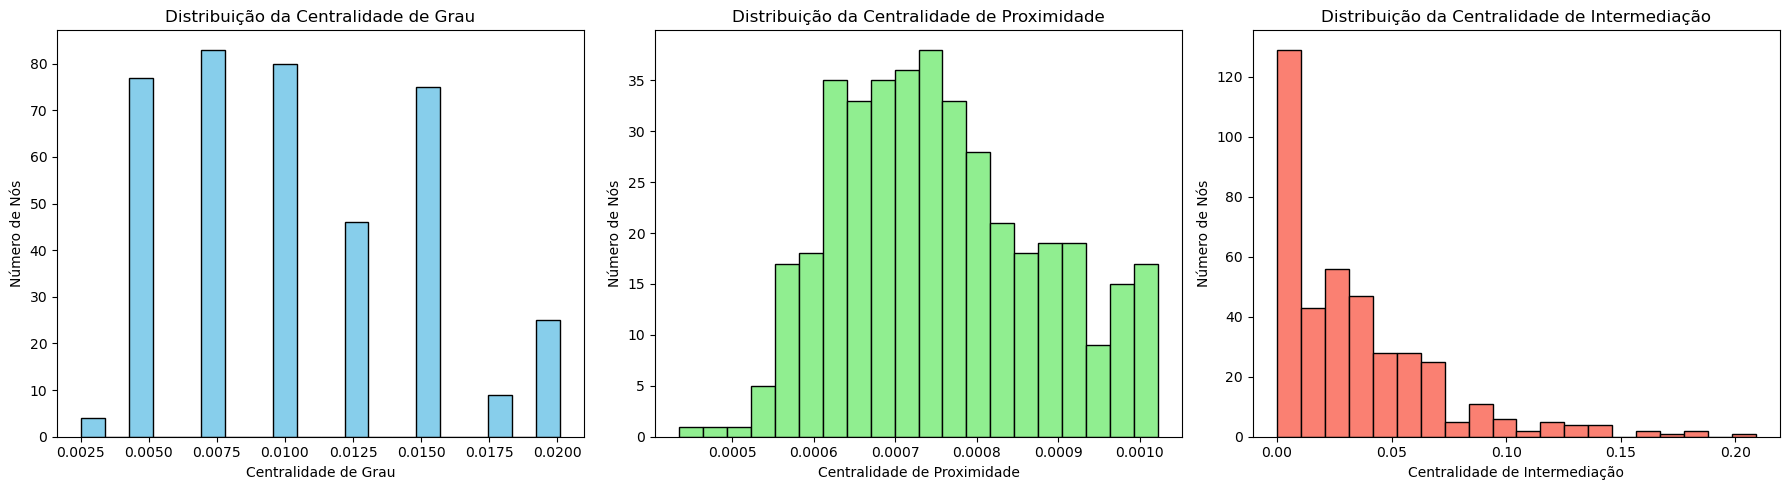

In [38]:
# Criar uma figura com 3 colunas e 1 linha
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plotar a distribuição da centralidade de grau
axes[0].hist(centralidade_grau_total.values(), bins=20, color="skyblue", edgecolor="black")
axes[0].set_xlabel("Centralidade de Grau")
axes[0].set_ylabel("Número de Nós")
axes[0].set_title("Distribuição da Centralidade de Grau")

# Plotar a distribuição da centralidade de proximidade
axes[1].hist(centralidade_proximidade_total.values(), bins=20, color="lightgreen", edgecolor="black")
axes[1].set_xlabel("Centralidade de Proximidade")
axes[1].set_ylabel("Número de Nós")
axes[1].set_title("Distribuição da Centralidade de Proximidade")

# Criar um DataFrame para a centralidade de intermediação e plotar o histograma
axes[2].hist(centralidade_intermediacao.values(), bins=20, color="salmon", edgecolor="black")
axes[2].set_xlabel("Centralidade de Intermediação")
axes[2].set_ylabel("Número de Nós")
axes[2].set_title("Distribuição da Centralidade de Intermediação")

# Ajustar o layout e exibir o gráfico
plt.tight_layout()
plt.show()

Os histogramas fornecem uma visão detalhada sobre a conectividade e acessibilidade dos nós na rede viária. O histograma da centralidade de grau mostra a quantidade de conexões diretas de cada nó, representando a conectividade local. A distribuição apresenta picos concentrados principalmente entre 0,005 e 0,015, indicando que a maioria dos nós possui um número moderado de conexões, característicos de interseções simples. Apenas alguns nós possuem valores mais altos de centralidade de grau, sugerindo interseções principais, conectadas a várias ruas.

O histograma da centralidade de proximidade reflete como os nós estão distribuídos em relação à acessibilidade de toda a rede. A maioria dos nós apresenta valores entre 0,0006 e 0,0010, indicando que a rede viária é razoavelmente bem conectada, permitindo alcançar a maior parte dos nós em poucas etapas. A baixa presença de valores extremos, tanto baixos quanto altos, sugere uma rede homogênea em termos de acessibilidade, sem áreas isoladas ou desproporcionalmente conectadas.

Já o histograma da centralidade de intermediação revela que a maioria dos nós possui valores próximos de zero, com apenas alguns exibindo valores elevados. Esse padrão reflete que poucos nós desempenham papéis estratégicos como pontos de passagem em caminhos mais curtos entre outros nós. Esses nós, com alta centralidade de intermediação, representam interseções principais ou pontos críticos para o fluxo de tráfego, enquanto a maioria dos nós é composta por terminais ou interseções menos significativas para o fluxo geral.

Em resumo, os histogramas mostram que a rede viária apresenta uma estrutura hierárquica: a centralidade de grau aponta para uma maioria de nós com conectividade moderada e alguns altamente conectados; a centralidade de proximidade indica uma acessibilidade bem distribuída, sem grandes desigualdades; e a centralidade de intermediação destaca poucos nós como cruciais para a conectividade global e o fluxo entre diferentes partes da rede.



## 3.5 Cálculo da orientação da rede

O cálculo da orientação da rede em redes espaciais refere-se à análise das direções predominantes dos segmentos de conexão, como ruas, trilhas ou qualquer outro tipo de conexão espacial. Esse processo permite identificar as direções ou ângulos mais frequentes dos segmentos em uma determinada área, revelando padrões de organização espacial e o layout da rede. A orientação é geralmente expressa em graus (de 0 a 360) ou em radianos e é frequentemente visualizada em gráficos polares ou histogramas que representam os ângulos das conexões.

A análise de orientação permite extrair informações relevantes sobre a estrutura e organização da rede. Em redes com estrutura planejada, como bairros ou áreas construídas com regularidade, é comum encontrar orientações dominantes, como segmentos dispostos em ângulos retos ou seguindo uma mesma direção. Em contrapartida, em redes formadas de maneira orgânica, como trilhas em florestas ou caminhos em áreas rurais, a orientação dos segmentos tende a ser mais variada e sem direções predominantes. Essa análise revela se a rede segue um padrão organizado ou apresenta uma estrutura mais aleatória.

O cálculo da orientação pode também ser usado para comparar diferentes regiões, setores ou áreas dentro de uma rede espacial. Áreas planejadas geralmente exibem orientações mais consistentes, enquanto áreas desenvolvidas de forma não estruturada apresentam orientações mais dispersas. Essa comparação é útil para identificar contrastes entre áreas com planejamento e sem planejamento, bem como para observar o impacto do desenvolvimento urbano ou natural.

A orientação dos segmentos impacta ainda a forma como os indivíduos percebem e navegam pela rede. Em redes organizadas (por exemplo, com segmentos perpendiculares ou paralelos), é mais fácil para as pessoas se localizarem e encontrarem rotas. Em redes mais caóticas, com orientações diversas, a navegação pode ser mais desafiadora.

Além disso, redes com orientações uniformes, como aquelas dispostas em ângulos consistentes, tendem a oferecer caminhos mais curtos e eficientes, enquanto redes com segmentos orientados de forma irregular podem aumentar o comprimento dos trajetos.


Para analisar a orientação, inicialmente vamos transformar o grafo em um grafo não-direcionado. Isso é necessário porque estamos interessados apenas na direção das ruas, independentemente do sentido de direção de cada via.
Além disso, vamos adicionar aos segmentos de rua (arestas) o atributo de "bearing" (orientação), que indica o ângulo de cada segmento em relação ao norte.

In [39]:
grafo_nao_direcionado = ox.add_edge_bearings(ox.convert.to_undirected(grafo_rede_viaria))

Para visualizar a orientação de forma clara, vamos criar um gráfico polar. Essa projeção permite mostrar os ângulos em um círculo, destacando as direções predominantes das ruas.

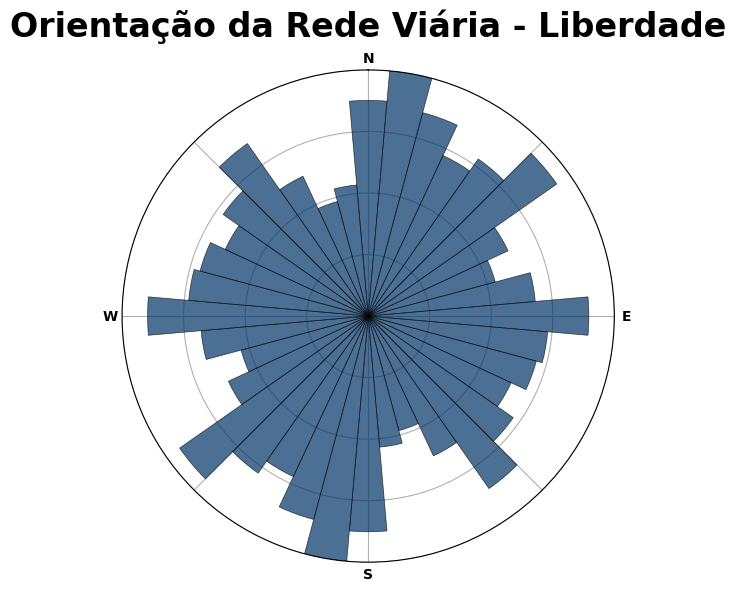

In [40]:
# Configurar a Visualização com Projeção Polar
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={"projection": "polar"})

# Gerar o Histograma de Orientação
ox.plot_orientation(grafo_nao_direcionado, ax=ax, title="Orientação da Rede Viária - Liberdade", area=True)

# Plotar
plt.show()

O gráfico de orientação apresenta a distribuição das direções das ruas do bairro da Liberdade, em relação aos pontos cardeais (Norte, Sul, Leste e Oeste).

As barras representam a quantidade de segmentos de rua orientados em cada direção específica, com a altura de cada barra indicando essa quantidade. As direções mostram picos em diversas posições, sugerindo que as ruas não seguem uma única orientação predominante, mas sim uma variedade de direções distribuídas de forma relativamente uniforme.

Em termos de *padrões de orientação*, esses múltiplos picos ao redor do círculo indicam que o bairro da Liberdade possui ruas orientadas em várias direções, com uma leve predominância nos eixos Norte-Sul e Leste-Oeste. A presença dessas múltiplas orientações sugere um crescimento urbano menos planejado, ou adaptado à topografia local, onde o traçado das ruas foi moldado de acordo com o terreno e as construções existentes, em vez de seguir um layout estritamente ortogonal.

Na *análise de organização espacial*, a ausência de um padrão claro e dominante nas direções das ruas (como uma forte predominância em Norte-Sul e Leste-Oeste) indica que o bairro não apresenta uma estrutura viária em grade regular, característica de áreas planejadas. Essa variedade de orientações pode afetar a trafegabilidade e a percepção espacial, tornando a área potencialmente mais confusa para quem não conhece bem a região.